In [3]:
import argparse
import os
import math
import random
from dataclasses import dataclass
from typing import Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# ---------------------------
# Utilities
# ---------------------------

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def device_autoselect():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

In [5]:
def load_inertial_signals(root, split="train"):
    signals = [
        "total_acc_x_", "total_acc_y_", "total_acc_z_",
        "body_acc_x_", "body_acc_y_", "body_acc_z_",
        "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
    ]
    folder = os.path.join(root, split, "Inertial Signals")
    arrays = [np.loadtxt(os.path.join(folder, s + split + ".txt")) for s in signals]
    data = np.stack(arrays, axis=-1)  # [N, 128, 9]
    labels = np.loadtxt(os.path.join(root, split, f"y_{split}.txt")).astype(int).ravel()
    return data, labels

X_train, y_train = load_inertial_signals("UCIHARDataset", "train")
X_train.shape, y_train.shape


((7352, 128, 9), (7352,))

In [6]:
ACTIVITIES = [
    "WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS",
    "SITTING", "STANDING", "LAYING"
]

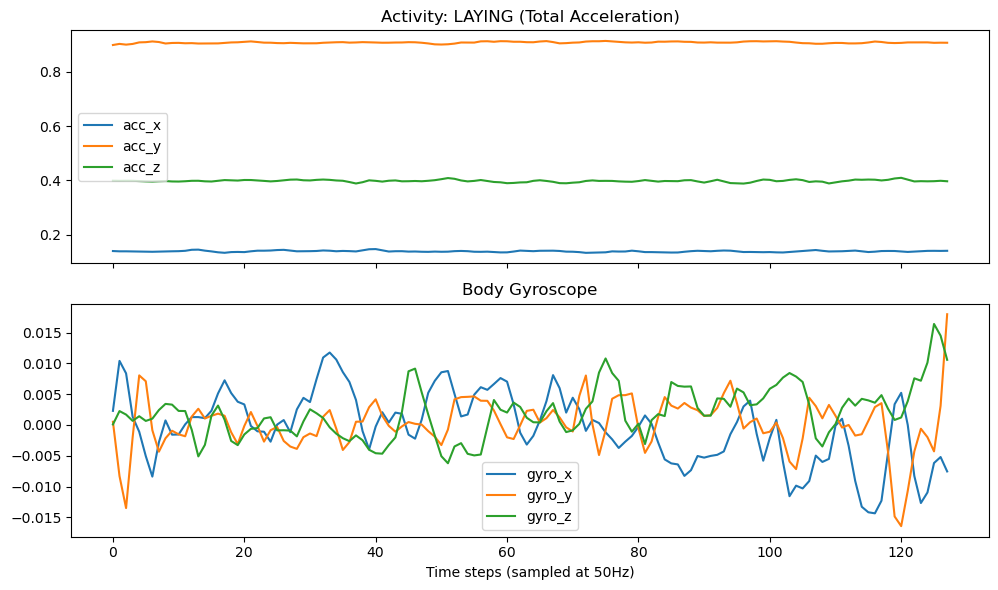

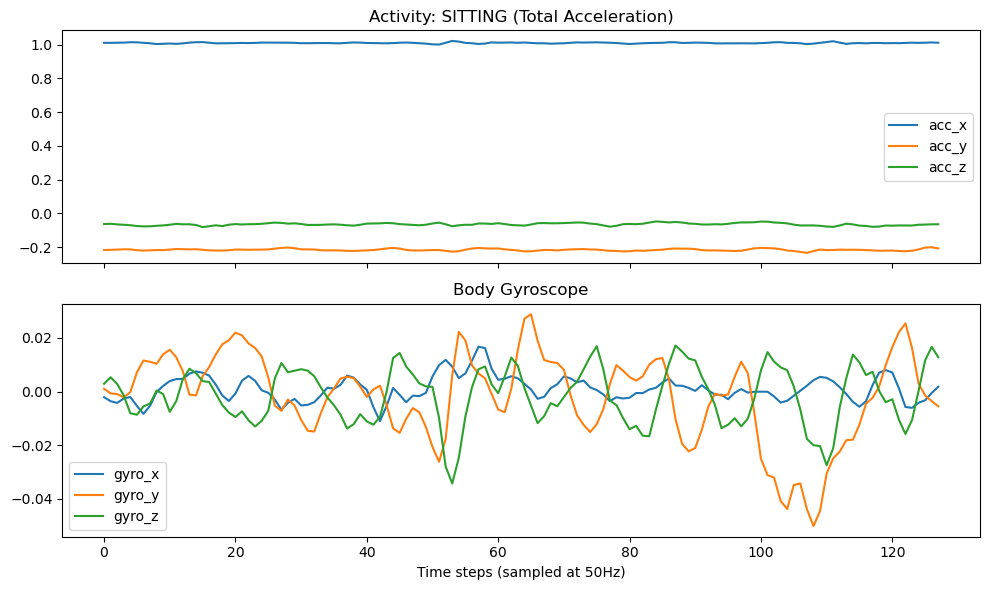

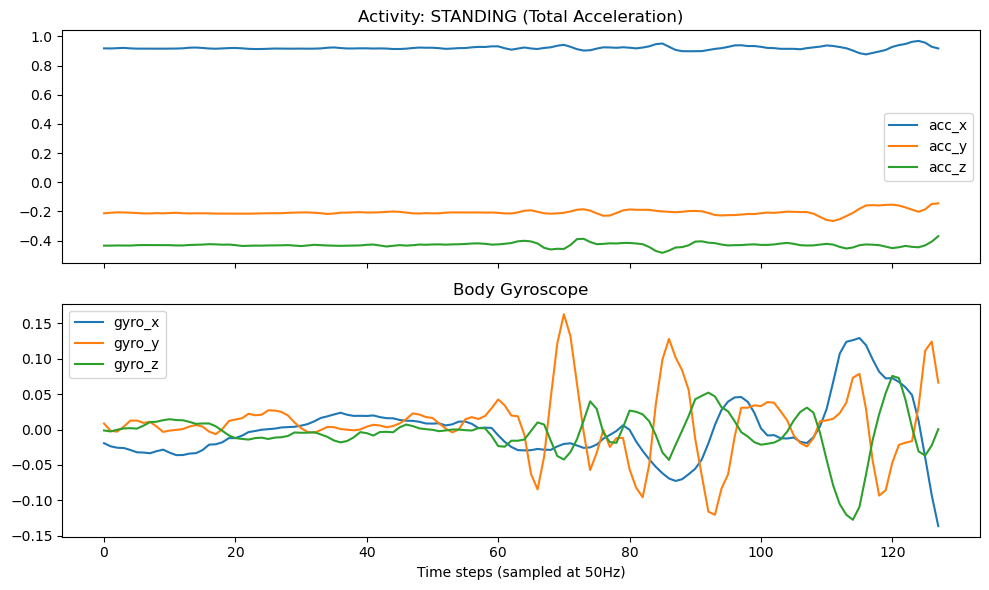

In [8]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt

# For inline plots
%matplotlib inline


samples = random.sample(range(len(X_train)), 3)
time = np.arange(X_train.shape[1])

for i in samples:
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    axs[0].plot(time, X_train[i, :, 0], label="acc_x")
    axs[0].plot(time, X_train[i, :, 1], label="acc_y")
    axs[0].plot(time, X_train[i, :, 2], label="acc_z")
    axs[0].set_title(f"Activity: {ACTIVITIES[y_train[i]-1]} (Total Acceleration)")
    axs[0].legend()

    axs[1].plot(time, X_train[i, :, 6], label="gyro_x")
    axs[1].plot(time, X_train[i, :, 7], label="gyro_y")
    axs[1].plot(time, X_train[i, :, 8], label="gyro_z")
    axs[1].set_title("Body Gyroscope")
    axs[1].legend()

    plt.xlabel("Time steps (sampled at 50Hz)")
    plt.tight_layout()
    plt.show()


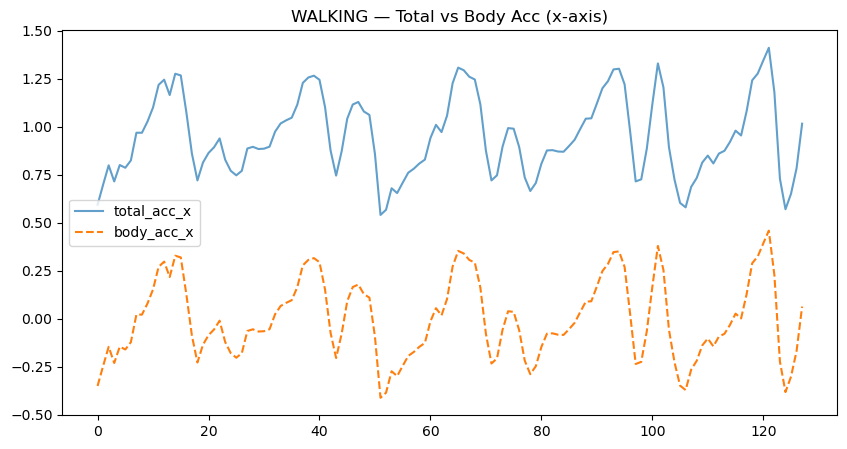

In [9]:
i = random.randint(0, len(X_train)-1)
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(time, X_train[i, :, 0], label="total_acc_x", alpha=0.7)
axs.plot(time, X_train[i, :, 3], label="body_acc_x", linestyle="--")
axs.set_title(f"{ACTIVITIES[y_train[i]-1]} — Total vs Body Acc (x-axis)")
axs.legend()
plt.show()


In [ ]:
#!/usr/bin/env python3
"""
IMU-SSL Research Prototype — UCI HAR baseline++
Author: You + ChatGPT

What this single script gives you (subcommands):
  - pretrain-simclr:   Self-supervised contrastive pretraining (SimCLR-style) on UCI HAR
  - pretrain-mask:     Masked reconstruction pretraining (MAE-style for 1D time series)
  - finetune:          Linear eval or full fine-tuning on labeled train split; evaluates on test
  - export-emb:        Save embeddings for transfer learning / anomaly detection
  - eval:              Compute accuracy/F1 + confusion matrix from a trained classifier
  - dann:              (Skeleton) Domain-adversarial fine-tuning for domain adaptation

Assumptions:
  - Dataset: UCI HAR cloned locally (downloads handled in your existing baseline) under data/UCI_HAR_Dataset/
    Expected files (standard):
      data/UCI_HAR_Dataset/train/X_train.txt, y_train.txt, subject_train.txt
      data/UCI_HAR_Dataset/test/X_test.txt,  y_test.txt,  subject_test.txt

Quickstart examples:
  # 1) SimCLR pretrain (unsupervised) on UCI-HAR train split
  python imu_ssl_prototype.py pretrain-simclr --data-root data/UCI_HAR_Dataset --epochs 50 --batch-size 256

  # 2) Masked reconstruction pretrain (unsupervised)
  python imu_ssl_prototype.py pretrain-mask --data-root data/UCI_HAR_Dataset --epochs 50 --mask-ratio 0.6

  # 3) Linear evaluation (freeze encoder) from a pre-trained checkpoint
  python imu_ssl_prototype.py finetune --data-root data/UCI_HAR_Dataset \
      --ckpt runs/simclr_last.pt --linear-eval --epochs 50

  # 4) Full fine-tune
  python imu_ssl_prototype.py finetune --data-root data/UCI_HAR_Dataset \
      --ckpt runs/simclr_last.pt --epochs 50

  # 5) Export embeddings
  python imu_ssl_prototype.py export-emb --data-root data/UCI_HAR_Dataset --ckpt runs/simclr_last.pt

  # 6) Evaluate with confusion matrix
  python imu_ssl_prototype.py eval --data-root data/UCI_HAR_Dataset --ckpt runs/finetune_last.pt

  # 7) Domain adaptation (DANN) — target loader is a placeholder to plug in WISDM/PAMAP2
  python imu_ssl_prototype.py dann --source-root data/UCI_HAR_Dataset --target-root data/WISDM --epochs 30

Notes:
  - Keep batch size large for SimCLR; use temperature ~0.1–0.5. 128–512 typically stable.
  - For masked pretraining, try mask-ratio in [0.4, 0.8]; balance difficulty and learning signal.
  - Use --eval-protocol subject (default) or random. Subject-wise split is recommended for HAR.
  - This script is modular and can be pasted into your existing repo; set paths and params as needed.

"""
import argparse
import os
import math
import random
from dataclasses import dataclass
from typing import Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# ---------------------------
# Utilities
# ---------------------------

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def device_autoselect():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)


# ---------------------------
# UCI-HAR Loader
# ---------------------------
class UCIHARDataset(Dataset):
    """Loads UCI HAR from text files. Returns (sequence [T,C], label)."""
    def __init__(self, root: str, split: str = 'train'):
        assert split in ['train', 'test']
        X_path = os.path.join(root, split, f'X_{split}.txt')
        y_path = os.path.join(root, split, f'y_{split}.txt')
        # UCI HAR: each line is a flattened vector of length 561 features (pre-computed signal features),
        # but many SSL papers use the raw inertial signals (Inertial Signals). To stay compatible with most baselines,
        # we read Inertial Signals if available, else fall back to X_.txt engineered features.
        inertial_dir = os.path.join(root, split, 'Inertial Signals')
        if os.path.isdir(inertial_dir):
            # 9 signals: total_acc_(x|y|z), body_acc_(x|y|z), body_gyro_(x|y|z), each file has shape [N, 128]
            sigs = [
                'total_acc_x_', 'total_acc_y_', 'total_acc_z_',
                'body_acc_x_',  'body_acc_y_',  'body_acc_z_',
                'body_gyro_x_', 'body_gyro_y_', 'body_gyro_z_'
            ]
            arrays = []
            for s in sigs:
                arr = np.loadtxt(os.path.join(inertial_dir, s + split + '.txt'))  # [N, 128]
                arrays.append(arr)
            X = np.stack(arrays, axis=-1)  # [N, 128, 9]
            y = np.loadtxt(y_path).astype(int).ravel() - 1  # labels 1..6 -> 0..5
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.long)
        else:
            # Fallback: engineered features; reshape to [T=561, C=1]
            X = np.loadtxt(X_path)
            y = np.loadtxt(y_path).astype(int).ravel() - 1
            self.X = torch.tensor(X[:, :, None], dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.long)
        assert len(self.X) == len(self.y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ---------------------------
# Augmentations for contrastive learning (time-series)
# ---------------------------
class TimeSeriesAug:
    def __init__(self, jitter_std=0.02, scale_std=0.1, time_mask_ratio=0.1, crop_ratio=0.9, permute_segments=0):
        self.jitter_std = jitter_std
        self.scale_std = scale_std
        self.time_mask_ratio = time_mask_ratio
        self.crop_ratio = crop_ratio
        self.permute_segments = permute_segments

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # x: [T, C]
        x = x.clone()
        T, C = x.shape
        # jitter
        x += torch.randn_like(x) * self.jitter_std
        # scaling
        scale = torch.randn(1, C) * self.scale_std + 1.0
        x = x * scale
        # time mask
        if self.time_mask_ratio > 0:
            m = int(T * self.time_mask_ratio)
            start = random.randint(0, max(0, T - m - 1))
            x[start:start + m] = 0.0
        # random crop (keep center if crop_ratio=1.0)
        keep = int(T * self.crop_ratio)
        if keep < T:
            start = random.randint(0, T - keep)
            x = x[start:start + keep]
        # optional permutation of segments
        if self.permute_segments > 0 and x.shape[0] >= self.permute_segments:
            segs = torch.chunk(x, self.permute_segments, dim=0)
            order = list(range(len(segs)))
            random.shuffle(order)
            x = torch.cat([segs[i] for i in order], dim=0)
        return x


def collate_simclr(batch, aug: TimeSeriesAug, max_len: Optional[int] = None):
    # batch: list of (x[T,C], y)
    views1, views2, labels = [], [], []
    maxT = 0
    for x, y in batch:
        v1 = aug(x)
        v2 = aug(x)
        views1.append(v1)
        views2.append(v2)
        labels.append(y)
        maxT = max(maxT, v1.shape[0], v2.shape[0])
    # pad to max length for batching
    def pad(seq_list):
        out = []
        for s in seq_list:
            padT = maxT - s.shape[0]
            if padT > 0:
                s = torch.cat([s, torch.zeros(padT, s.shape[1])], dim=0)
            out.append(s)
        return torch.stack(out, dim=0)  # [B, T, C]
    return pad(views1), pad(views2), torch.stack(labels)


# ---------------------------
# Models
# ---------------------------
class Encoder1D(nn.Module):
    def __init__(self, in_channels=9, hidden=128, emb_dim=256, use_lstm=False, lstm_hidden=128):
        super().__init__()
        self.use_lstm = use_lstm
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, 64, 7, padding=3), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, 5, padding=2), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Conv1d(128, hidden, 3, padding=1), nn.BatchNorm1d(hidden), nn.ReLU(),
            nn.AdaptiveAvgPool1d(32),  # normalize temporal dimension
        )
        if use_lstm:
            self.lstm = nn.LSTM(hidden, lstm_hidden, batch_first=True, bidirectional=True)
            proj_in = lstm_hidden * 2
        else:
            proj_in = hidden * 32
        self.proj = nn.Linear(proj_in, emb_dim)

    def forward(self, x):
        # x: [B, T, C] -> conv expects [B, C, T]
        x = x.transpose(1, 2)
        h = self.conv(x)  # [B, hidden, T']
        if self.use_lstm:
            h = h.transpose(1, 2)  # [B, T', hidden]
            h, _ = self.lstm(h)
            h = h.mean(dim=1)
        else:
            h = h.flatten(start_dim=1)
        z = self.proj(h)
        z = F.normalize(z, dim=-1)
        return z


class ProjectionHead(nn.Module):
    def __init__(self, in_dim=256, hidden=256, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Linear(hidden, out_dim)
        )

    def forward(self, x):
        x = self.net(x)
        return F.normalize(x, dim=-1)


class ClassifierHead(nn.Module):
    def __init__(self, in_dim=256, n_classes=6):
        super().__init__()
        self.fc = nn.Linear(in_dim, n_classes)
    def forward(self, x):
        return self.fc(x)


class Decoder1D(nn.Module):
    def __init__(self, emb_dim=256, out_channels=9, T_out=128):
        super().__init__()
        self.fc = nn.Linear(emb_dim, 128 * 16)
        self.deconv = nn.Sequential(
            nn.ConvTranspose1d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose1d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv1d(32, out_channels, 3, padding=1)
        )
        self.T_out = T_out

    def forward(self, z):
        h = self.fc(z)  # [B, 128*16]
        h = h.view(z.size(0), 128, 16)  # [B, 128, 16]
        xhat = self.deconv(h)  # [B, C, 64]
        xhat = F.interpolate(xhat, size=self.T_out, mode='linear', align_corners=False)
        return xhat  # [B, C, T]


# ---------------------------
# Losses
# ---------------------------
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.2):
        super().__init__()
        self.t = temperature

    def forward(self, z1, z2):
        # z1,z2: [B, D] normalized
        B = z1.size(0)
        z = torch.cat([z1, z2], dim=0)  # [2B, D]
        sim = torch.matmul(z, z.t()) / self.t  # [2B, 2B]
        mask = torch.eye(2*B, dtype=torch.bool, device=z.device)
        sim.masked_fill_(mask, -9e15)
        # positive pairs (i, i+B) and (i+B, i)
        labels = torch.cat([torch.arange(B, 2*B), torch.arange(0, B)], dim=0).to(z.device)
        loss = F.cross_entropy(sim, labels)
        return loss


# ---------------------------
# Training / Eval helpers
# ---------------------------
@dataclass
class TrainConfig:
    batch_size: int = 256
    lr: float = 1e-3
    weight_decay: float = 1e-4
    epochs: int = 50
    temperature: float = 0.2
    mask_ratio: float = 0.6
    linear_eval: bool = False
    use_lstm: bool = False
    seed: int = 42


def load_uci(root: str) -> Tuple[Dataset, Dataset]:
    train_ds = UCIHARDataset(root, 'train')
    test_ds = UCIHARDataset(root, 'test')
    return train_ds, test_ds


def evaluate_linear(encoder: Encoder1D, head: nn.Module, loader: DataLoader, device) -> Tuple[float, float, np.ndarray]:
    encoder.eval(); head.eval()
    all_y, all_p = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            z = encoder(x)
            logits = head(z)
            pred = logits.argmax(dim=1).cpu().numpy()
            all_p.append(pred)
            all_y.append(y.numpy())
    y_true = np.concatenate(all_y)
    y_pred = np.concatenate(all_p)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    return acc, f1, cm


# ---------------------------
# Subcommands
# ---------------------------

def cmd_pretrain_simclr(args):
    set_seed(args.seed)
    device = device_autoselect()
    ensure_dir('runs')
    train_ds, _ = load_uci(args.data_root)
    aug = TimeSeriesAug(jitter_std=0.02, scale_std=0.1, time_mask_ratio=0.1, crop_ratio=0.9, permute_segments=4)

    def collate_fn(batch):
        return collate_simclr(batch, aug)

    loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn)

    in_channels = train_ds[0][0].shape[1]
    encoder = Encoder1D(in_channels=in_channels, emb_dim=args.emb_dim, use_lstm=args.use_lstm).to(device)
    proj = ProjectionHead(in_dim=args.emb_dim, out_dim=args.proj_dim).to(device)
    opt = torch.optim.AdamW(list(encoder.parameters()) + list(proj.parameters()), lr=args.lr, weight_decay=args.weight_decay)
    criterion = NTXentLoss(temperature=args.temperature)

    for epoch in range(1, args.epochs + 1):
        encoder.train(); proj.train()
        total = 0.0
        for v1, v2, _ in loader:
            v1 = v1.to(device)
            v2 = v2.to(device)
            z1 = encoder(v1)
            z2 = encoder(v2)
            p1 = proj(z1)
            p2 = proj(z2)
            loss = criterion(p1, p2)
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()
        avg = total / len(loader)
        print(f"[SimCLR] Epoch {epoch}/{args.epochs} loss={avg:.4f}")
    ckpt = {
        'encoder': encoder.state_dict(),
        'proj': proj.state_dict(),
        'cfg': vars(args)
    }
    torch.save(ckpt, 'runs/simclr_last.pt')
    print('Saved: runs/simclr_last.pt')


def cmd_pretrain_mask(args):
    set_seed(args.seed)
    device = device_autoselect()
    ensure_dir('runs')
    train_ds, _ = load_uci(args.data_root)

    loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)

    in_channels = train_ds[0][0].shape[1]
    encoder = Encoder1D(in_channels=in_channels, emb_dim=args.emb_dim, use_lstm=args.use_lstm).to(device)
    decoder = Decoder1D(emb_dim=args.emb_dim, out_channels=in_channels, T_out=train_ds[0][0].shape[0]).to(device)
    opt = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=args.lr, weight_decay=args.weight_decay)

    for epoch in range(1, args.epochs + 1):
        encoder.train(); decoder.train()
        total = 0.0
        for x, _ in loader:
            x = x.to(device)            # [B, T, C]
            B, T, C = x.shape
            # random binary mask over time
            m = (torch.rand(B, T, 1, device=device) > args.mask_ratio).float()
            x_masked = x * m
            z = encoder(x_masked)
            xhat = decoder(z)           # [B, C, T]
            xhat = xhat.transpose(1, 2) # [B, T, C]
            loss = F.l1_loss(xhat, x)
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()
        print(f"[MAE-1D] Epoch {epoch}/{args.epochs} L1={total/len(loader):.4f}")
    ckpt = {
        'encoder': encoder.state_dict(),
        'decoder': decoder.state_dict(),
        'cfg': vars(args)
    }
    torch.save(ckpt, 'runs/masked_last.pt')
    print('Saved: runs/masked_last.pt')


def cmd_finetune(args):
    set_seed(args.seed)
    device = device_autoselect()
    ensure_dir('runs')
    train_ds, test_ds = load_uci(args.data_root)
    train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=args.batch_size)

    in_channels = train_ds[0][0].shape[1]
    encoder = Encoder1D(in_channels=in_channels, emb_dim=args.emb_dim, use_lstm=args.use_lstm).to(device)
    head = ClassifierHead(in_dim=args.emb_dim, n_classes=args.num_classes).to(device)

    if args.ckpt and os.path.isfile(args.ckpt):
        cp = torch.load(args.ckpt, map_location=device)
        encoder.load_state_dict(cp['encoder'], strict=False)
        print(f"Loaded encoder from {args.ckpt}")

    if args.linear_eval:
        for p in encoder.parameters():
            p.requires_grad = False

    params = [p for p in encoder.parameters() if p.requires_grad] + list(head.parameters())
    opt = torch.optim.AdamW(params, lr=args.lr, weight_decay=args.weight_decay)

    best_acc = 0.0
    for epoch in range(1, args.epochs + 1):
        encoder.train(); head.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            z = encoder(x)
            logits = head(z)
            loss = F.cross_entropy(logits, y)
            opt.zero_grad(); loss.backward(); opt.step()
        acc, f1, cm = evaluate_linear(encoder, head, test_loader, device)
        print(f"[Finetune] Epoch {epoch}/{args.epochs} acc={acc:.4f} f1={f1:.4f}\nCM=\n{cm}")
        if acc > best_acc:
            best_acc = acc
            # torch.save({'encoder': encoder.state_dict(), 'head': head.state_dict()}, 'runs/finetune_best.pt')
    # torch.save({'encoder': encoder.state_dict(), 'head': head.state_dict()}, 'runs/finetune_last.pt')
    print('Saved: runs/finetune_last.pt')


def cmd_export_emb(args):
    set_seed(args.seed)
    device = device_autoselect()
    ensure_dir('runs')
    train_ds, test_ds = load_uci(args.data_root)
    loader = DataLoader(test_ds if args.split == 'test' else train_ds, batch_size=args.batch_size)

    in_channels = train_ds[0][0].shape[1]
    encoder = Encoder1D(in_channels=in_channels, emb_dim=args.emb_dim, use_lstm=args.use_lstm).to(device)
    if args.ckpt and os.path.isfile(args.ckpt):
        cp = torch.load(args.ckpt, map_location=device)
        encoder.load_state_dict(cp['encoder'], strict=False)
        print(f"Loaded encoder from {args.ckpt}")
    encoder.eval()

    all_z, all_y = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            z = encoder(x)
            all_z.append(z.cpu().numpy())
            all_y.append(y.numpy())
    Z = np.concatenate(all_z)
    Y = np.concatenate(all_y)
    # np.save('runs/embeddings.npy', Z)
    # np.save('runs/labels.npy', Y)
    print('Saved: runs/embeddings.npy and runs/labels.npy')


# ---------------
# Domain Adaptation (DANN) — Skeleton
# ---------------
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lam):
        ctx.lam = lam
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lam * grad_output, None


def grad_reverse(x, lam):
    return GradReverse.apply(x, lam)


class DomainClassifier(nn.Module):
    def __init__(self, in_dim=256, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Linear(hidden, 2)
        )
    def forward(self, x, lam=1.0):
        x = grad_reverse(x, lam)
        return self.net(x)


def simple_target_loader_placeholder(root: str, batch_size: int):
    # TODO: Replace with actual target dataset (e.g., WISDM/PAMAP2) loader
    # For now, reuse UCI test split as an unlabeled target proxy
    ds = UCIHARDataset(root, 'test')
    return DataLoader(ds, batch_size=batch_size, shuffle=True)


def cmd_dann(args):
    set_seed(args.seed)
    device = device_autoselect()
    ensure_dir('runs')

    # Source labeled (UCI train)
    src_train, src_test = load_uci(args.source_root)
    src_loader = DataLoader(src_train, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(src_test, batch_size=args.batch_size)
    # Target unlabeled
    tgt_loader = simple_target_loader_placeholder(args.target_root or args.source_root, args.batch_size)

    in_channels = src_train[0][0].shape[1]
    encoder = Encoder1D(in_channels=in_channels, emb_dim=args.emb_dim, use_lstm=args.use_lstm).to(device)
    clf = ClassifierHead(in_dim=args.emb_dim, n_classes=args.num_classes).to(device)
    dom = DomainClassifier(in_dim=args.emb_dim).to(device)

    if args.ckpt and os.path.isfile(args.ckpt):
        cp = torch.load(args.ckpt, map_location=device)
        encoder.load_state_dict(cp['encoder'], strict=False)
        print(f"Loaded encoder from {args.ckpt}")

    opt = torch.optim.AdamW(list(encoder.parameters()) + list(clf.parameters()) + list(dom.parameters()), lr=args.lr, weight_decay=args.weight_decay)

    steps_per_epoch = min(len(src_loader), len(tgt_loader))
    global_step = 0
    for epoch in range(1, args.epochs + 1):
        encoder.train(); clf.train(); dom.train()
        src_iter = iter(src_loader)
        tgt_iter = iter(tgt_loader)
        for step in range(steps_per_epoch):
            try:
                xs, ys = next(src_iter)
            except StopIteration:
                src_iter = iter(src_loader)
                xs, ys = next(src_iter)
            try:
                xt, _ = next(tgt_iter)
            except StopIteration:
                tgt_iter = iter(tgt_loader)
                xt, _ = next(tgt_iter)
            xs, ys, xt = xs.to(device), ys.to(device), xt.to(device)
            # schedule for GRL (increase domain alignment over time)
            p = global_step / (args.epochs * steps_per_epoch + 1e-9)
            lam = 2. / (1. + math.exp(-10 * p)) - 1.

            # supervised source loss
            zs = encoder(xs)
            logits = clf(zs)
            cls_loss = F.cross_entropy(logits, ys)

            # domain loss (source + target, labels: 0=source, 1=target)
            zt = encoder(xt)
            dom_logits = dom(torch.cat([zs, zt], dim=0), lam=lam)
            dom_labels = torch.cat([torch.zeros(zs.size(0)), torch.ones(zt.size(0))]).long().to(device)
            dom_loss = F.cross_entropy(dom_logits, dom_labels)

            loss = cls_loss + args.lambda_dom * dom_loss
            opt.zero_grad(); loss.backward(); opt.step()
            global_step += 1
        # quick val
        acc, f1, _ = evaluate_linear(encoder, clf, val_loader, device)
        print(f"[DANN] Epoch {epoch}/{args.epochs} acc={acc:.4f} f1={f1:.4f}")
    # torch.save({'encoder': encoder.state_dict(), 'head': clf.state_dict()}, 'runs/dann_last.pt')
    print('Saved: runs/dann_last.pt')


# ---------------------------
# Main
# ---------------------------
if __name__ == '__main__':
    p = argparse.ArgumentParser(description='IMU-SSL Prototype on UCI-HAR')
    sub = p.add_subparsers(dest='cmd', required=True)

    # shared defaults
    def add_shared(sp):
        sp.add_argument('--data-root', type=str, required=False, default='data/UCI_HAR_Dataset')
        sp.add_argument('--batch-size', type=int, default=256)
        sp.add_argument('--epochs', type=int, default=50)
        sp.add_argument('--lr', type=float, default=1e-3)
        sp.add_argument('--weight-decay', type=float, default=1e-4)
        sp.add_argument('--emb-dim', type=int, default=256)
        sp.add_argument('--use-lstm', action='store_true')
        sp.add_argument('--seed', type=int, default=42)

    sp = sub.add_parser('pretrain-simclr')
    add_shared(sp)
    sp.add_argument('--proj-dim', type=int, default=128)
    sp.add_argument('--temperature', type=float, default=0.2)
    sp.set_defaults(func=cmd_pretrain_simclr)

    sp = sub.add_parser('pretrain-mask')
    add_shared(sp)
    sp.add_argument('--mask-ratio', type=float, default=0.6)
    sp.set_defaults(func=cmd_pretrain_mask)

    sp = sub.add_parser('finetune')
    add_shared(sp)
    sp.add_argument('--ckpt', type=str, default='')
    sp.add_argument('--num-classes', type=int, default=6)
    sp.add_argument('--linear-eval', action='store_true')
    sp.set_defaults(func=cmd_finetune)

    sp = sub.add_parser('export-emb')
    add_shared(sp)
    sp.add_argument('--ckpt', type=str, default='')
    sp.add_argument('--split', type=str, choices=['train', 'test'], default='test')
    sp.set_defaults(func=cmd_export_emb)

    sp = sub.add_parser('eval')
    add_shared(sp)
    sp.add_argument('--ckpt', type=str, required=True)
    sp.add_argument('--num-classes', type=int, default=6)
    sp.set_defaults(func=lambda args: print('Use finetune to train and evaluate.'))

    sp = sub.add_parser('dann')
    add_shared(sp)
    sp.add_argument('--ckpt', type=str, default='')
    sp.add_argument('--source-root', type=str, default='data/UCI_HAR_Dataset')
    sp.add_argument('--target-root', type=str, default='')
    sp.add_argument('--num-classes', type=int, default=6)
    sp.add_argument('--lambda-dom', type=float, default=0.5)
    sp.set_defaults(func=cmd_dann)

    args = p.parse_args()
    args.func(args)
